In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
from sklearn.linear_model import ElasticNet
from sklearn import linear_model
from scipy.stats import skew
from math import sqrt

warnings.filterwarnings('ignore')
%matplotlib inline
pd.set_option('display.max_columns', 300)

In [257]:
#要調整的參數
min_corr = 0.5 #至少與我們要求的參數有多大的關係才保留
skew_max = 0.7 #當skew的絕對值小於這個值時我們不做處理
k = 3 #預測離群值所需的K值，愈大代表愈異常才剔除

In [228]:
#讀入資料`,並把要預測的分出來
df_train = pd.read_csv('../House_Prices/data/train.csv', index_col="Id")
df_test = pd.read_csv('../House_Prices/data/test.csv', index_col="Id")
y_train = df_train.SalePrice
df_train = df_train.drop(columns='SalePrice')

print(len(df_train._get_numeric_data().columns))
print(len(df_train.select_dtypes(include='object').columns))

36
43


In [229]:
#檢查資料
df_train.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

### 資料有可能遺漏
所以我們應該試著看看之前篩選出來的資料是否完整

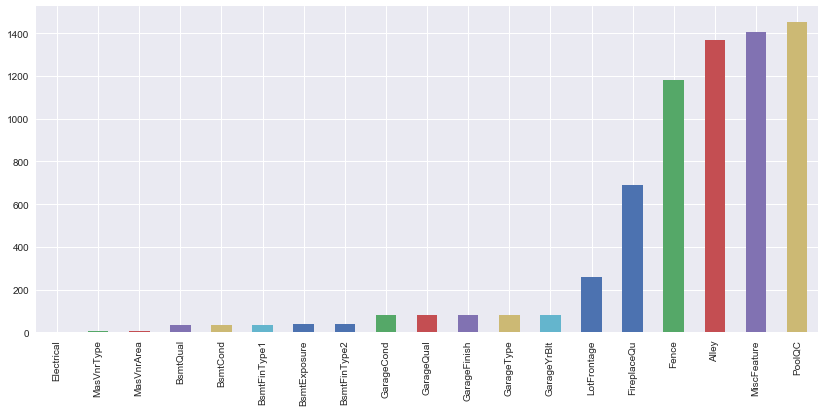

In [230]:
_, axes = plt.subplots(figsize=(14, 6))
missing = df_train.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar()

In [231]:
categorical_features = df_train.select_dtypes(include='object').columns
df_train[categorical_features] = df_train[categorical_features].fillna('None')
df_test[categorical_features] = df_test[categorical_features].fillna('None')

In [232]:
from sklearn.preprocessing import Imputer

# Replace NaN with corresponding Neighborhood Median
df_train["LotFrontage"] = df_train.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))
df_test["LotFrontage"] = df_test.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))
    
# Replace NaN with Feature Median 
numerical_features = df_train.select_dtypes(include='number').columns
my_imputer = Imputer()
df_train[numerical_features] = my_imputer.fit_transform(df_train[numerical_features])
df_test[numerical_features] = my_imputer.transform(df_test[numerical_features])

In [233]:
df_train[numerical_features]

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60.0,65.0,8450.0,7.0,5.0,2003.0,2003.0,196.0,706.0,0.0,150.0,856.0,856.0,854.0,0.0,1710.0,1.0,0.0,2.0,1.0,3.0,1.0,8.0,0.0,2003.000000,2.0,548.0,0.0,61.0,0.0,0.0,0.0,0.0,0.0,2.0,2008.0
2,20.0,80.0,9600.0,6.0,8.0,1976.0,1976.0,0.0,978.0,0.0,284.0,1262.0,1262.0,0.0,0.0,1262.0,0.0,1.0,2.0,0.0,3.0,1.0,6.0,1.0,1976.000000,2.0,460.0,298.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,2007.0
3,60.0,68.0,11250.0,7.0,5.0,2001.0,2002.0,162.0,486.0,0.0,434.0,920.0,920.0,866.0,0.0,1786.0,1.0,0.0,2.0,1.0,3.0,1.0,6.0,1.0,2001.000000,2.0,608.0,0.0,42.0,0.0,0.0,0.0,0.0,0.0,9.0,2008.0
4,70.0,60.0,9550.0,7.0,5.0,1915.0,1970.0,0.0,216.0,0.0,540.0,756.0,961.0,756.0,0.0,1717.0,1.0,0.0,1.0,0.0,3.0,1.0,7.0,1.0,1998.000000,3.0,642.0,0.0,35.0,272.0,0.0,0.0,0.0,0.0,2.0,2006.0
5,60.0,84.0,14260.0,8.0,5.0,2000.0,2000.0,350.0,655.0,0.0,490.0,1145.0,1145.0,1053.0,0.0,2198.0,1.0,0.0,2.0,1.0,4.0,1.0,9.0,1.0,2000.000000,3.0,836.0,192.0,84.0,0.0,0.0,0.0,0.0,0.0,12.0,2008.0
6,50.0,85.0,14115.0,5.0,5.0,1993.0,1995.0,0.0,732.0,0.0,64.0,796.0,796.0,566.0,0.0,1362.0,1.0,0.0,1.0,1.0,1.0,1.0,5.0,0.0,1993.000000,2.0,480.0,40.0,30.0,0.0,320.0,0.0,0.0,700.0,10.0,2009.0
7,20.0,75.0,10084.0,8.0,5.0,2004.0,2005.0,186.0,1369.0,0.0,317.0,1686.0,1694.0,0.0,0.0,1694.0,1.0,0.0,2.0,0.0,3.0,1.0,7.0,1.0,2004.000000,2.0,636.0,255.0,57.0,0.0,0.0,0.0,0.0,0.0,8.0,2007.0
8,60.0,80.0,10382.0,7.0,6.0,1973.0,1973.0,240.0,859.0,32.0,216.0,1107.0,1107.0,983.0,0.0,2090.0,1.0,0.0,2.0,1.0,3.0,1.0,7.0,2.0,1973.000000,2.0,484.0,235.0,204.0,228.0,0.0,0.0,0.0,350.0,11.0,2009.0
9,50.0,51.0,6120.0,7.0,5.0,1931.0,1950.0,0.0,0.0,0.0,952.0,952.0,1022.0,752.0,0.0,1774.0,0.0,0.0,2.0,0.0,2.0,2.0,8.0,2.0,1931.000000,2.0,468.0,90.0,0.0,205.0,0.0,0.0,0.0,0.0,4.0,2008.0


In [234]:
idx_split = df_train.shape[0]
df_train = df_train.append(df_test)

In [235]:
print(df_train.shape[0])

2919


### 2.3.2 Factorizing

In [236]:
NumStr = ["MSSubClass","BsmtFullBath","BsmtHalfBath","HalfBath","BedroomAbvGr","KitchenAbvGr","MoSold","YrSold","YearBuilt","YearRemodAdd","LowQualFinSF","GarageYrBlt"]
for col in NumStr:
    df_train[col]=df_train[col].astype(str)
    
non_ordinal_features = ['LandSlope','Utilities','MSZoning', 'Street','Alley','LotShape','LandContour','LotConfig','Neighborhood','Condition1','Condition2','BldgType','HouseStyle', 'RoofStyle','RoofMatl','Exterior1st', 'Exterior2nd','MasVnrType','Foundation', 'BsmtExposure','BsmtFinType1','BsmtFinType2', 'Heating', 'CentralAir', 'Electrical','Functional', 'GarageType','GarageFinish','PavedDrive', 'Fence','MiscFeature','SaleType','SaleCondition', "MSSubClass","BsmtFullBath","BsmtHalfBath","HalfBath","BedroomAbvGr","KitchenAbvGr","MoSold","YrSold","YearBuilt","YearRemodAdd","LowQualFinSF","GarageYrBlt"]
ordinal_features = df_train.select_dtypes(include='object').columns.drop(non_ordinal_features)

In [237]:
print(df_train.loc[:,ordinal_features])

     ExterQual ExterCond BsmtQual BsmtCond HeatingQC KitchenQual FireplaceQu  \
Id                                                                             
1           Gd        TA       Gd       TA        Ex          Gd        None   
2           TA        TA       Gd       TA        Ex          TA          TA   
3           Gd        TA       Gd       TA        Ex          Gd          TA   
4           TA        TA       TA       Gd        Gd          Gd          Gd   
5           Gd        TA       Gd       TA        Ex          Gd          TA   
6           TA        TA       Gd       TA        Ex          TA        None   
7           Gd        TA       Ex       TA        Ex          Gd          Gd   
8           TA        TA       Gd       TA        Ex          TA          TA   
9           TA        TA       TA       TA        Gd          TA          TA   
10          TA        TA       TA       TA        Ex          TA          TA   
11          TA        TA       TA       

### 2.3.3 Non-Ordinal Variables

In [238]:
dummies = pd.get_dummies(df_train.loc[:,non_ordinal_features], drop_first=True)
df_train = pd.concat([df_train,dummies], axis=1)
df_train = df_train.drop(non_ordinal_features,axis=1)

### 2.3.4 Ordinal Variables

In [239]:
def cat_to_num(x):
    if x=='Ex':
        return 5
    if x=='Gd':
        return 4
    if x=='TA':
        return 3
    if x=='Fa':
        return 2
    if x=='Po':
        return 1
    if x=='None':
        return 0

df_train.loc[:,ordinal_features] = df_train.loc[:,ordinal_features].applymap(cat_to_num)

### 2.3.5 Train-Test Split

In [240]:
df_train["TotalHouse"] = df_train["TotalBsmtSF"] + df_train["1stFlrSF"] + df_train["2ndFlrSF"]   
df_train["TotalHouse_OverallQual"] = df_train["TotalHouse"] * df_train["OverallQual"]
df_train["GrLivArea_OverallQual"] = df_train["GrLivArea"] * df_train["OverallQual"]

X = df_train.loc[:idx_split, :]
X_test = df_train.loc[idx_split+1:, :]

# 3 Exploratory Data Analysis

This EDA has the objectives described below, any actions will be taken during the Data Cleaning and Feature Engineering phases.

- Get a general feel for the dataset
- Discover predictors that are correlated between them which may lead to **multicollinearity issues**
- Find out which predictors are most correlated with the target, these are the **top potential predictors** and are good candidates for feature engineering. It will also be interesting to verify if these are actually the ones the model gives more weight
- Inspect the data distributions and identify **skewed distributions** and **potential outliers** which can negatively impact the model performance

## 3.1 Predictors-Target Join
Doing EDA is easier if the predictors and the labels are in the same dataframe

In [241]:
X = X.assign(SalePrice=y_train)

## 3.2 Target Variable
The target variable is right skewed, this makes sense since expensive houses are rarer. Having skewed distributions may negatively impact model performance, so we'll take care of this during data cleaning

0


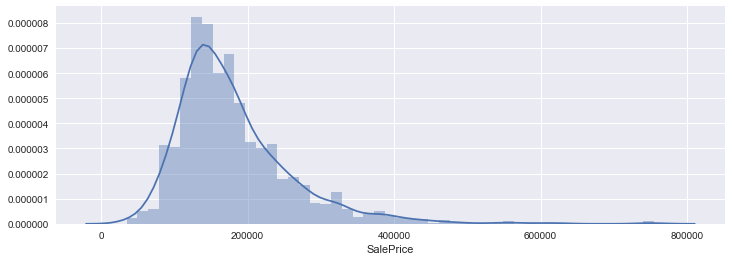

In [242]:
print(X.SalePrice.isnull().sum())
sns.set()
_, axes = plt.subplots(figsize=(12, 4))
sns.distplot(X.SalePrice)


## 3.3 Correlation Analysis
### 3.3.1 General Correlation
There are highly correlated features with each other this may result in multicollineariy during the modelling phase, these are the most troublesome features:
- GarageCars and GarageArea are highly correlated.
- PoolQC and PoolArea are highly correlated.
- Fireplaces and FireplaceQu are highly correlated.
- GarageCond and GarageCond are highly correlated

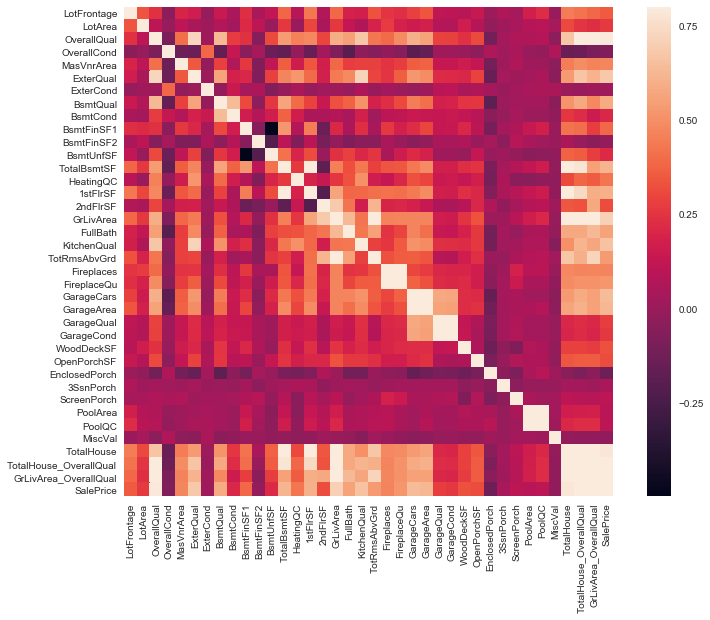

In [243]:
corrmat = X.drop(dummies,axis=1).corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

### 3.3.2 Correlation with Target
Here we plot the 10 most correlated features with our target to have an idea of which might be the best predictors, below are the descriptions of the features.

1. **OverallQual:** Rating of the material and finish of the house.
2. **GrLivArea:** Above ground living area in square feet, it's basically the area of the house excluding the basement. This means that it is related with two other features in the following manner: GrLivArea = 1stFlrSF + 2ndFlrSF
3. **ExterQual:** Evaluates the quality of the material on the exterior, it's interesting that although the description is similar to OverallQual they are not very correlated as seen on the previous plot.
4. **KitchenQual:** Just the general kitchen quality.
5. **GarageCars:**  Size of garage in car capacity.
6. **GarageArea:** Size of garage in square feet, hence why it is correlated with GarageCars, they measure pretty much the same thing using different metrics.
7. **TotalBsmtSF:** Area of the Basement in square feet.
8. **1stFlrSF:** Area of the First Floor in square feet.
9. **BsmtQual:** Evaluates the height of the basement.
10. **FullBath:** Number of full bathrooms above the ground.

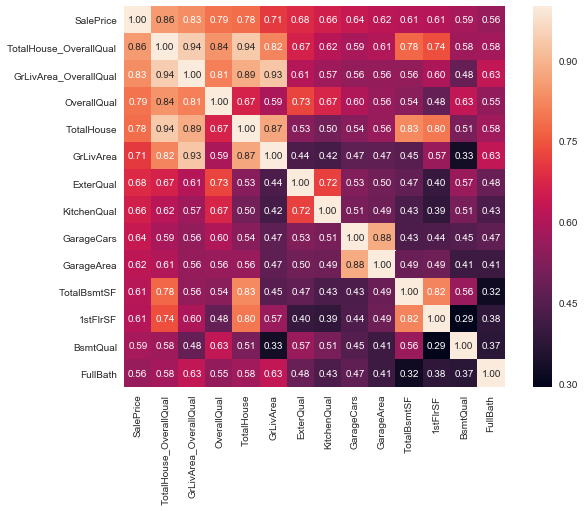

In [244]:
_, ax = plt.subplots(ncols=1, figsize=(10,7))
cols = corrmat.nlargest(14, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(X[cols].values.T)
sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)

## 3.4 Numerical Features

The objective here is to plot the Numerical Features in order to understand their distributions and if they have outliers, below are some of the reached conclusions:

- In most numerical features there are some outliers, in fact they are the same points for all features. This are indeed unwanted outliers as can be seen in the dataset description, so they were removed.
- There are some skewed distributions so we might have to take care of this.

### 3.4.1 OverallQual

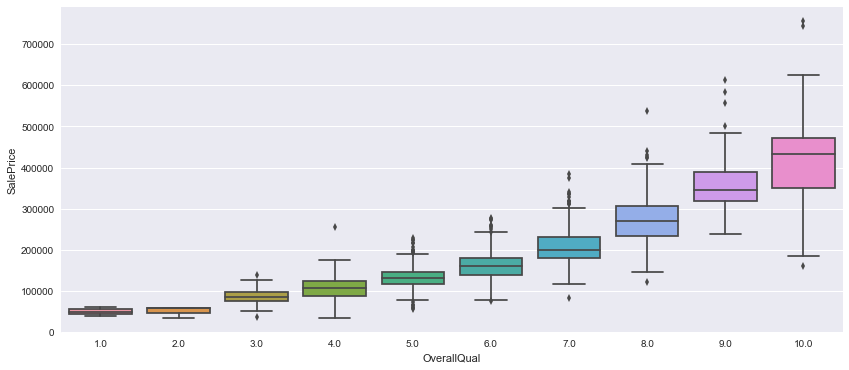

In [245]:
_, axes = plt.subplots(figsize=(14, 6))
sns.boxplot(x='OverallQual', y='SalePrice', data=X)

### 3.4.2 GrLivArea

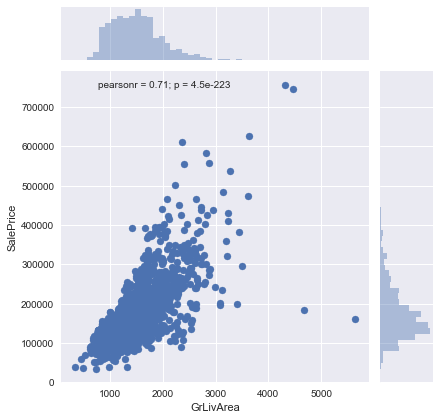

In [246]:
sns.set()
sns.jointplot(kind='scatter',data=X, x='GrLivArea', y='SalePrice')

### 3.4.3 TotalBsmtSF

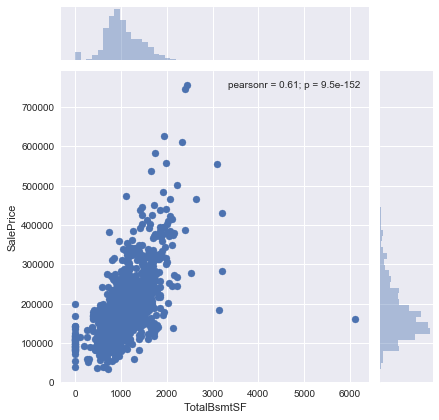

In [247]:
sns.set()
sns.jointplot(kind='scatter',data=X, x='TotalBsmtSF', y='SalePrice')

### 3.4.4  1stFlrSF

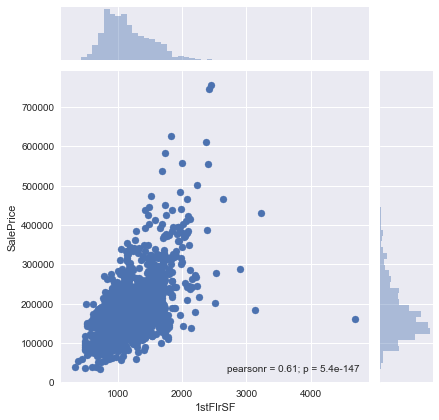

In [248]:
sns.set()
sns.jointplot(kind='scatter',data=X, x='1stFlrSF', y='SalePrice')

## 3.5 Predictors-Target Split
Here I dropped the target again, because we don't want to have our target as a predictor when we're modelling.

In [249]:
X = X.drop(columns='SalePrice')

# 4 Feature Engineering

Here the objective is to engineer some extra features to help our model understand relations between them:

- **TotalHouse:** The total area of the house including the basement
- **TotalHouse_OverallQual:** The total area of the house times the overall quality, this proved to be the most weighted feature for Lasso
- **GrLivArea_OverallQual:** The area of the house excluding the basement times the overall quality

In [250]:



X_test["TotalHouse"] = X_test["TotalBsmtSF"] + X_test["1stFlrSF"] + X_test["2ndFlrSF"]   
X_test["TotalHouse_OverallQual"] = X_test["TotalHouse"] * X_test["OverallQual"]
X_test["GrLivArea_OverallQual"] = X_test["GrLivArea"] * X_test["OverallQual"]


# 5 Data Cleaning

Here the objective is to clean the data based on the EDA we did previously, here are some conclusions:
- The previously detected outliers were removed
- All features with skewness above 0.75 are boxcox transformed
- The four multicollinear features we identified previously are removed
- All features are scaled using MinMaxScaling since it gave better results comparing to Standard and Robust

## 5.1 Handling Outliers

In [251]:
print(X[(X['GrLivArea']>4000) & (y_train<300000)].index)
X = X.drop(X[(X['GrLivArea']>4000) & (y_train<300000)].index)
y_train = y_train.drop([524, 1299])

Int64Index([524, 1299], dtype='int64', name='Id')


## 5.2 Feature Normalization

In [252]:
numeric_feats = X.dtypes[X.dtypes != "object"].index
numeric_feats = numeric_feats.drop(dummies)
numeric_feats = numeric_feats.drop(ordinal_features)

skewed_feats = X[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness = skewness[abs(skewness) > 0.75]

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    X[feat] = boxcox1p(X[feat], lam)
    X_test[feat] = boxcox1p(X_test[feat], lam)

In [253]:
y_train = np.log(y_train)

## 5.3 Avoiding Multicollinearity

In [258]:
multicol_features = ['GarageCars', 'PoolQC', 'FireplaceQu', 'GarageCond']
X = X.drop(multicol_features, axis = 1)
X_test = X_test.drop(multicol_features, axis = 1)

## 5.4 Feature Scaling

In [255]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaler.fit(X)

X[X.columns] = scaler.transform(X[X.columns])
X_test[X_test.columns] = scaler.transform(X_test[X_test.columns])

In [264]:
remaining = []
log = [] # 記住誰用了log
for i in df_train.columns:
    if (df_train[i]==0).sum() == 0 and df_train[i].skew()>skew_max:
        print(i)
        print("skewness %f" % df_train[i].skew())
        #res = stats.probplot(df_train[i], plot=plt)
        #df_train['SalePrice'] = np.log(df_train['SalePrice'])
        #sns.distplot(df_train[i], fit=norm);
        X[i] = np.log(X[i])
        X_test[i] = np.log(X_test[i])
        log += [i]
        print("skewness %f" % df_train[i].skew())
    elif np.absolute(df_train[i].skew()) <= skew_max :
        print(i)
        print("skewness %f" % df_train[i].skew())
        continue
    else:
        remaining += [i]
print("remaining :" + str(remaining))

LotArea
skewness -0.505542
OverallQual
skewness 0.197212
OverallCond
skewness 0.570605
ExterQual
skewness 0.392449
ExterCond
skewness -0.483412
HeatingQC
skewness -0.550192
1stFlrSF
skewness 0.063895
GrLivArea
skewness 0.012386
FullBath
skewness 0.167692
KitchenQual
skewness 0.387022
TotRmsAbvGrd
skewness -0.087471
FireplaceQu
skewness 0.172269
GarageCars
skewness -0.218411
GarageArea
skewness 0.241341
LotShape_Reg
skewness -0.569479
HouseStyle_1Story
skewness -0.015767
Exterior1st_VinylSd
skewness 0.624009
Exterior2nd_VinylSd
skewness 0.641408
MasVnrType_None
skewness -0.429807
Foundation_CBlock
skewness 0.311505
Foundation_PConc
skewness 0.208840
BsmtExposure_No
skewness -0.639821
GarageType_Attchd
skewness -0.367304
GarageFinish_Unf
skewness 0.318617
MSSubClass_20.0
skewness 0.540366
BsmtFullBath_1.0
skewness 0.402051
HalfBath_1.0
skewness 0.569479
BedroomAbvGr_3.0
skewness -0.187970
TotalHouse
skewness -0.362933
TotalHouse_OverallQual
skewness -0.568648
GrLivArea_OverallQual
skewne

In [256]:
corr_sale = (corrmat[corrmat['SalePrice'] > min_corr])['SalePrice'] #找出關聯性大於min_corr的
corr_sale.drop('SalePrice',inplace=True) # 
print(corr_sale.index)

Index(['OverallQual', 'ExterQual', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea',
       'KitchenQual', 'GarageCars', 'GarageArea', 'TotalHouse',
       'TotalHouse_OverallQual', 'GrLivArea_OverallQual'],
      dtype='object')


In [199]:
#a = [] 用來看看是哪些值有關連的list
de = []
for i in corr_sale.index:
    for j in corr_sale.index:
        if corrmat[i][j] > 0.8 and i!=j and (not i in de) and (not j in de):
            if corr_sale[i] > corr_sale[j]:
                corr_sale.drop(j, inplace=True)
                #a += [[i,j]]
                de += [j]
            else:
                corr_sale.drop(i, inplace=True)
                #a += [[i,j]]
                de += [i]

print(de) #印出被剃除的資料
print(corr_sale) #印出剩下的資料

['OverallQual', '1stFlrSF', 'TotalBsmtSF', 'GrLivArea', 'GarageArea', 'TotalHouse', 'GrLivArea_OverallQual']
ExterQual                 0.682639
KitchenQual               0.659600
GarageCars                0.640409
TotalHouse_OverallQual    0.856148
Name: SalePrice, dtype: float64


 ### 離群值
 - 有些資料中的值可能比較太小或太大，有可能會是輸入錯誤，或其他原因
 - 而他們會影響到我們的預測，所以必須把其剃除掉
 - 在這裡，我們簡單用上四分位數和下四分位數來預測離群估測值

In [202]:
print(y_train)

Id
1       12.247694
2       12.109011
3       12.317167
4       11.849398
5       12.429216
6       11.870600
7       12.634603
8       12.206073
9       11.774520
10      11.678440
11      11.771436
12      12.751300
13      11.877569
14      12.540758
15      11.964001
16      11.790557
17      11.911702
18      11.407565
19      11.976659
20      11.842229
21      12.692503
22      11.845103
23      12.345835
24      11.774520
25      11.944708
26      12.454104
27      11.811547
28      12.631340
29      12.242887
30      11.134589
          ...    
1431    12.165980
1432    11.875831
1433    11.074421
1434    12.136187
1435    11.982929
1436    12.066811
1437    11.699405
1438    12.885671
1439    11.916389
1440    12.190959
1441    12.160029
1442    11.913713
1443    12.644328
1444    11.703546
1445    12.098487
1446    11.767568
1447    11.969717
1448    12.388394
1449    11.626254
1450    11.429544
1451    11.820410
1452    12.567551
1453    11.884489
1454    11.344507
1455   

LotFrontage
LotArea
OverallQual
OverallCond
MasVnrArea
ExterQual
ExterCond
BsmtQual
BsmtCond
BsmtFinSF1
BsmtFinSF2
BsmtUnfSF
TotalBsmtSF
HeatingQC
1stFlrSF
2ndFlrSF
GrLivArea
FullBath
KitchenQual
TotRmsAbvGrd
Fireplaces
GarageArea
GarageQual
WoodDeckSF
OpenPorchSF
EnclosedPorch
3SsnPorch
ScreenPorch
PoolArea
MiscVal
TotalHouse
TotalHouse_OverallQual
GrLivArea_OverallQual


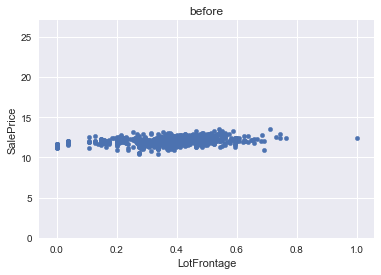

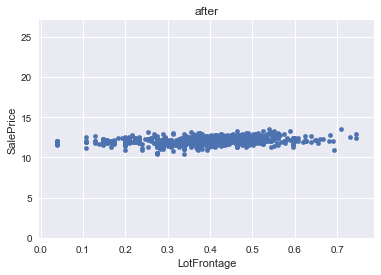

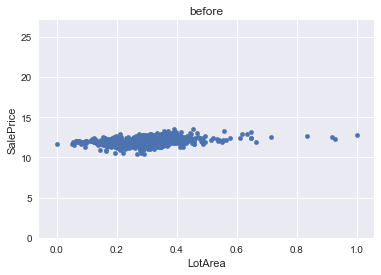

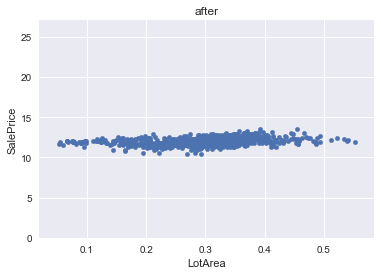

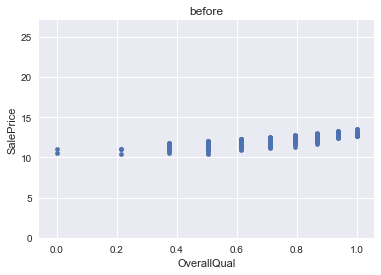

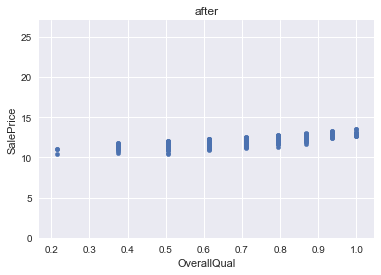

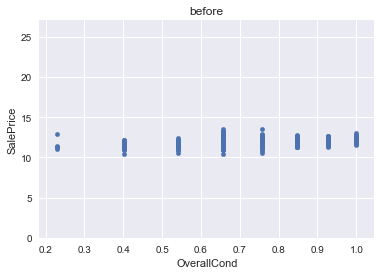

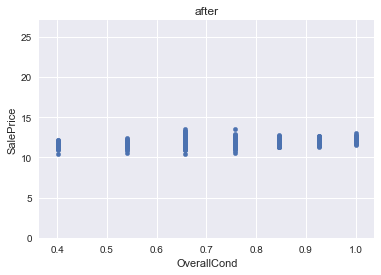

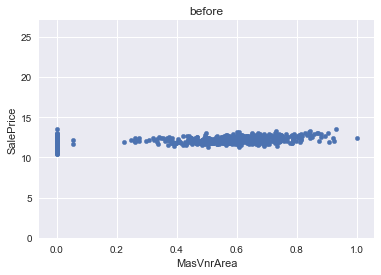

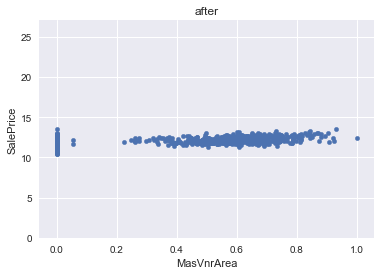

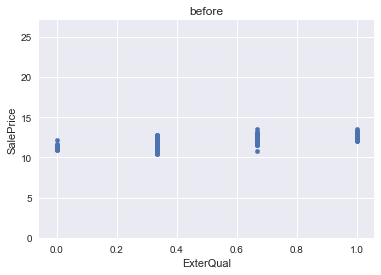

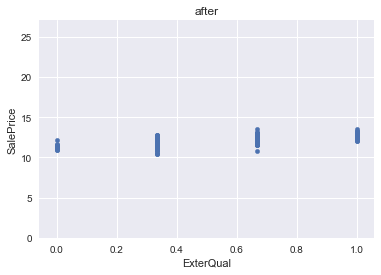

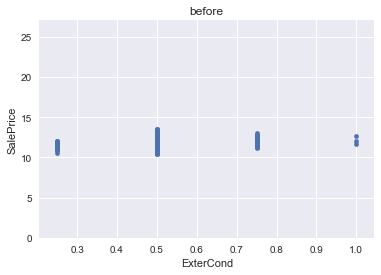

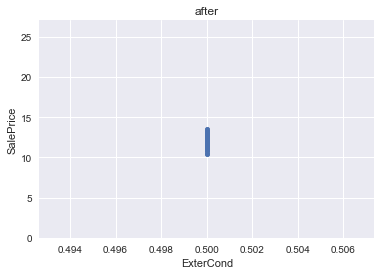

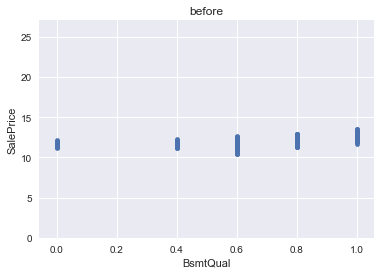

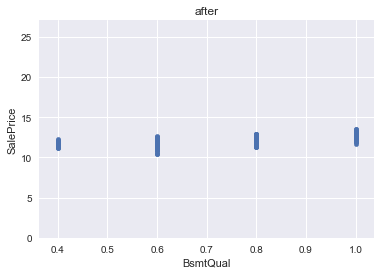

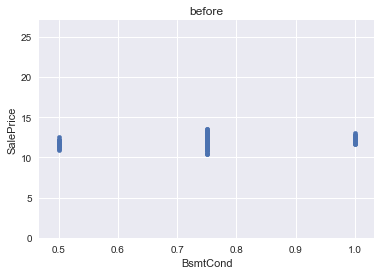

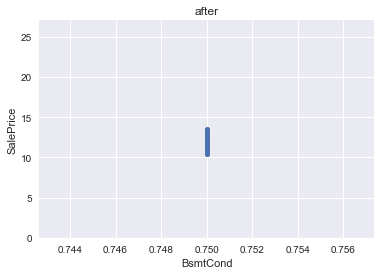

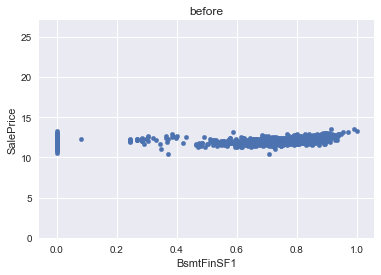

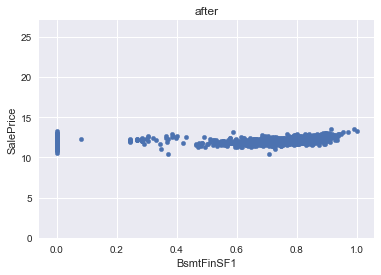

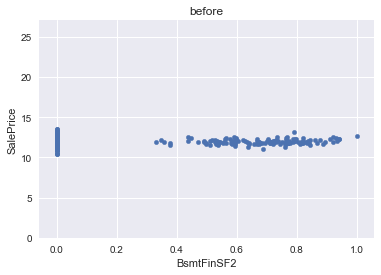

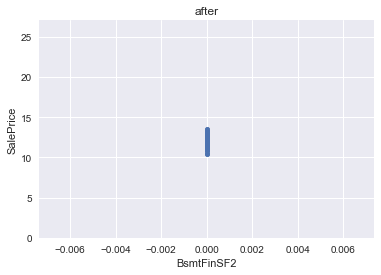

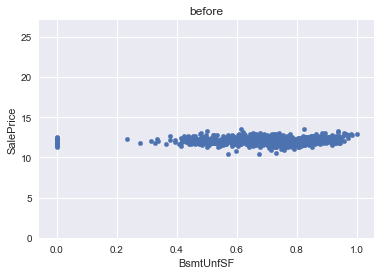

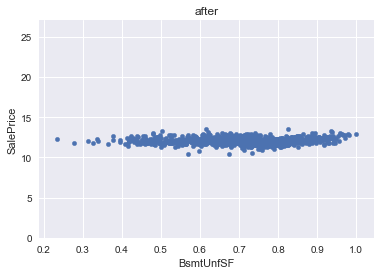

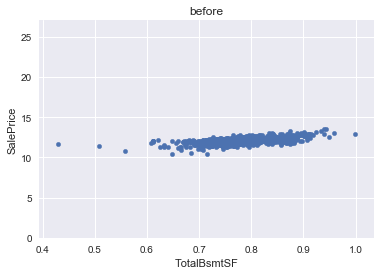

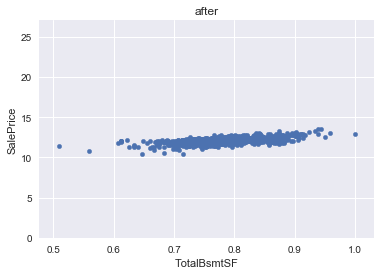

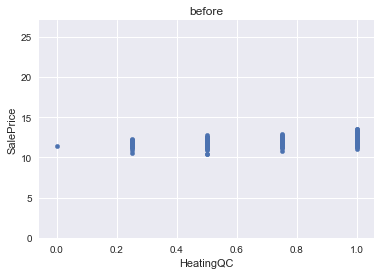

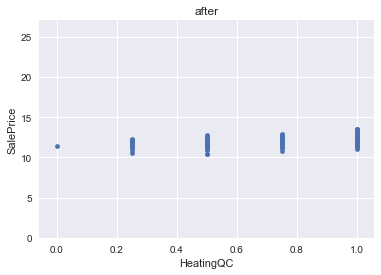

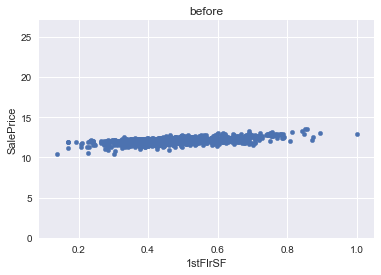

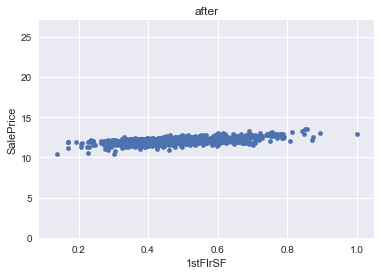

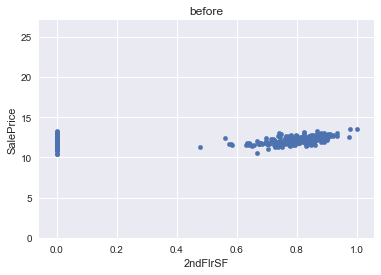

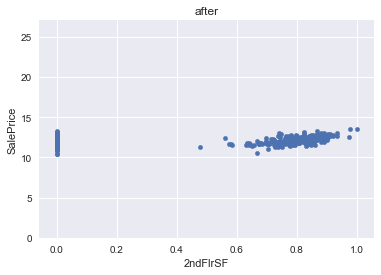

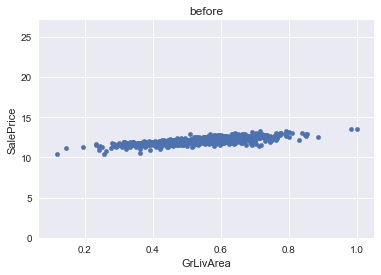

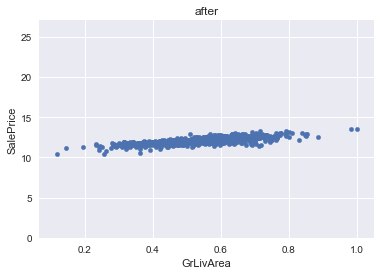

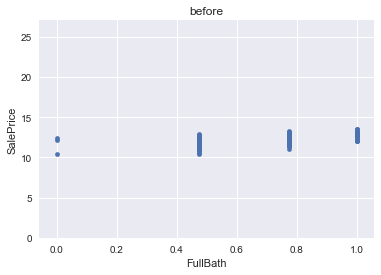

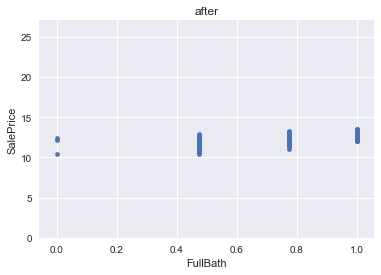

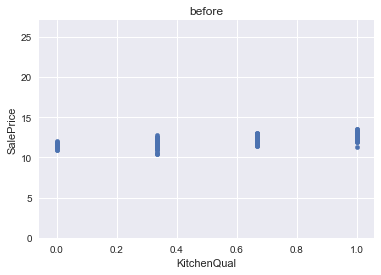

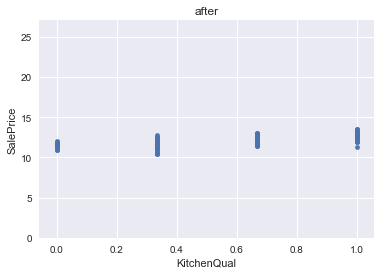

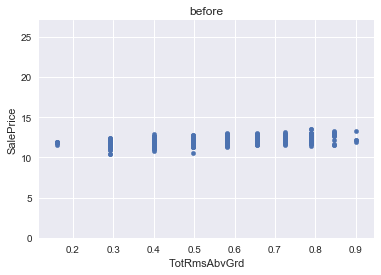

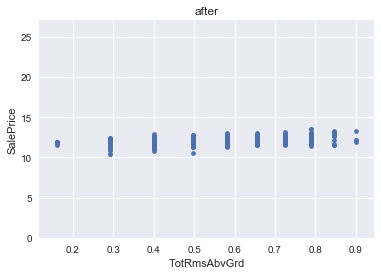

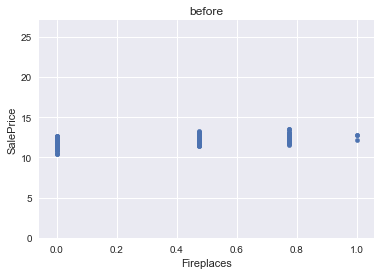

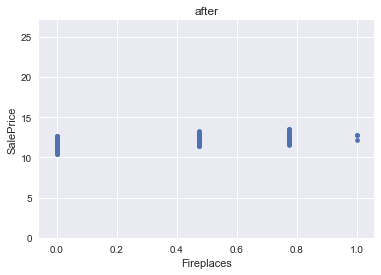

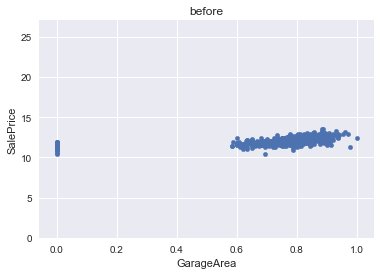

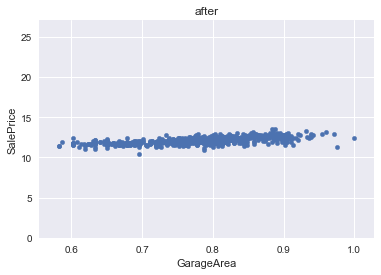

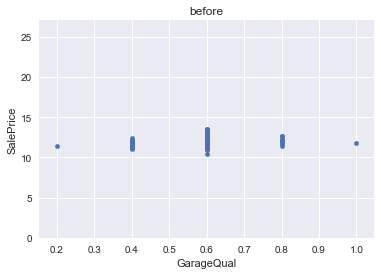

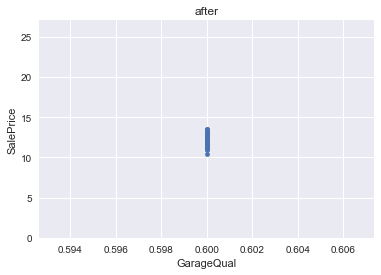

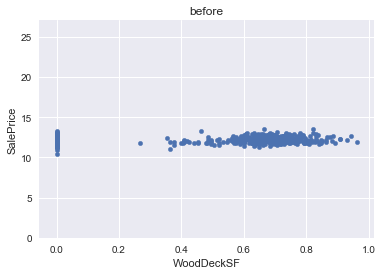

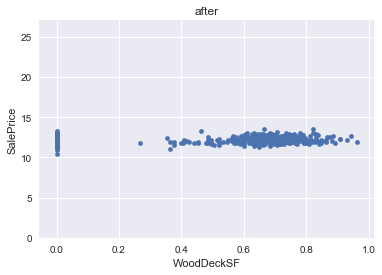

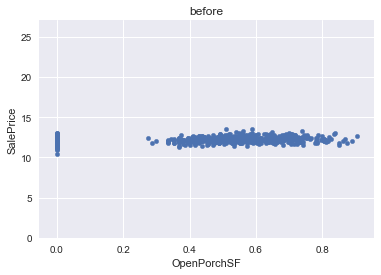

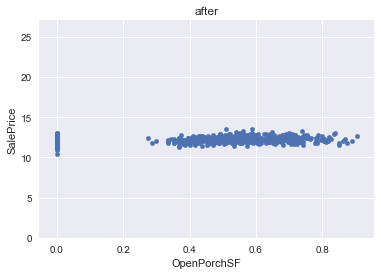

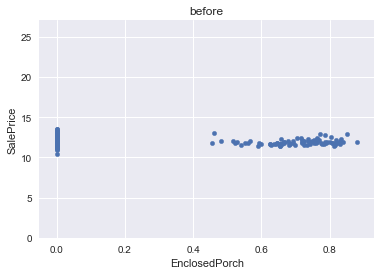

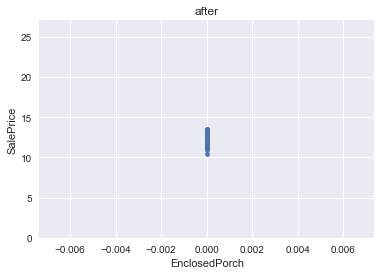

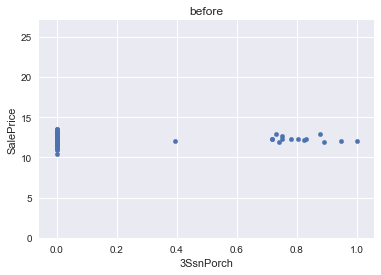

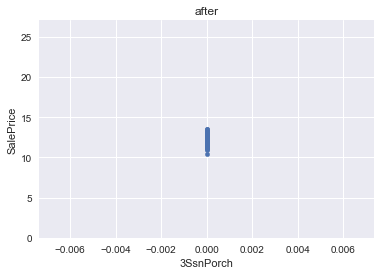

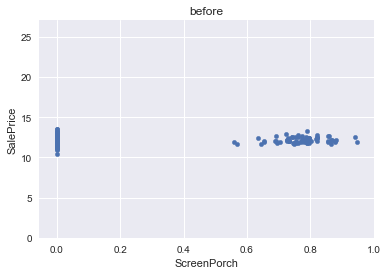

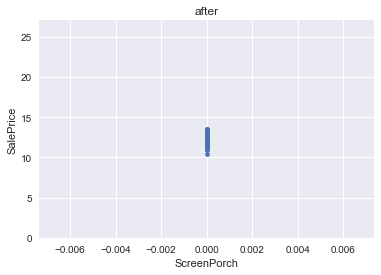

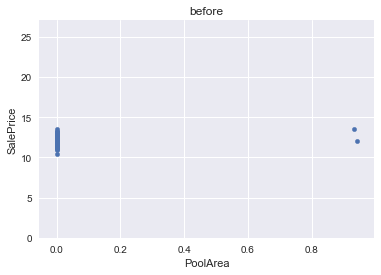

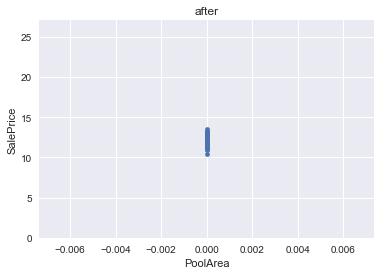

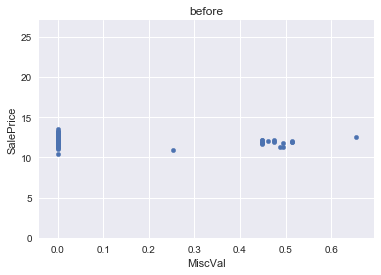

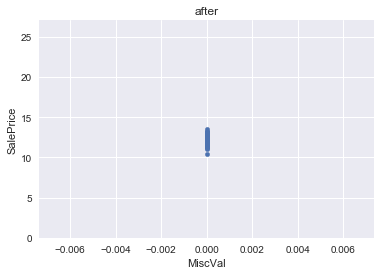

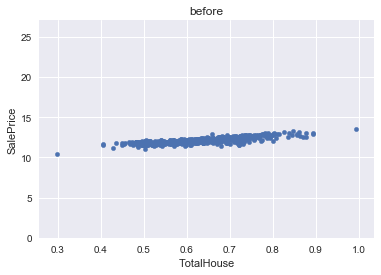

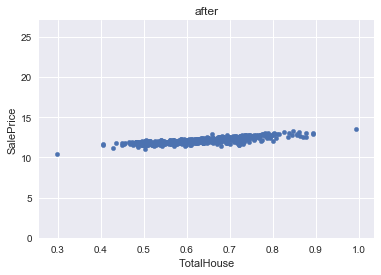

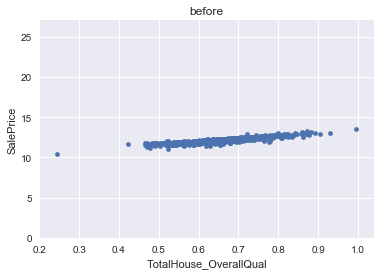

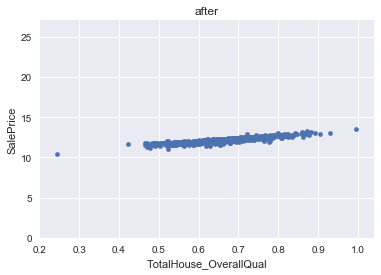

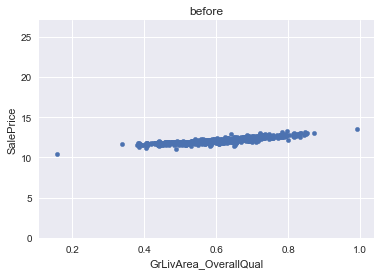

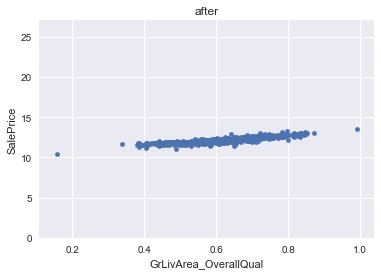

In [267]:
for i in X.drop(dummies, axis=1).columns:
    print(i)
    data = pd.concat([y_train, X[i]], axis=1)
    data.plot.scatter(x=i, y='SalePrice', title="before", ylim=(0,2*y_train.max()));
    q1, medium, q3 = np.percentile(X[i], [25, 50, 75])
    h_e, l_e = q3 + k*(q3-q1), q1 - k*(q3-q1)
    #print(X[i])
    high = (X[X[i] > h_e])[i]
    #print(high.index)
    X.drop(high.index, inplace=True)
    low = (X[X[i] < l_e])[i]
    #print(low.index)
    X.drop(low.index, inplace=True)
    data = pd.concat([y_train, X[i]], axis=1)
    data.plot.scatter(x=i, y='SalePrice', title="after", ylim=(0,2*y_train.max()));

### 正規化
簡單而言，我們要讓數據看起來是常態分布，有許多統計的測試都依賴這個。<br>
當skew太高或太低於+-0.7時，我才打算幫他一把，不然他已經夠好了。
<br>
我們用兩種圖來觀測資料是否為常態分佈
- Histogram - 以藍色線表示目前的分布情形，黑色線為理想常態分佈
- Normal probability plot- 以藍色點表示資料分布情況，以紅線表示理想常態分佈

In [2]:
#用SalePrice畫出這兩種圖
print("skewness %f" % df_train['SalePrice'].skew())#確認其skew過高
sns.distplot(df_train['SalePrice'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train['SalePrice'], plot=plt)

NameError: name 'df_train' is not defined

我們看得出剛剛的圖形明顯表示其並不是常態分佈，在統計學上呈現positive skewness，即Histogram的峰偏左。<br>
我們可以簡單用log來處理，通常用log來轉換後成果都很不錯。

In [ ]:
df_train['SalePrice'] = np.log(df_train['SalePrice'])

In [ ]:
sns.distplot(df_train['SalePrice'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train['SalePrice'], plot=plt)

可以看到他的資料已經很接近常態分佈了<br>
接下來我們對一樣是positive skewness，且skew太高的做一樣的事，不過得注意等於0的數值，他們不能被log

In [213]:
remaining = []
log = [] # 記住誰用了log
for i in corr_sale.index:
    print(i)
    print("skewness %f" % X_test[i].skew())

ExterQual
skewness 0.750313
KitchenQual
skewness 0.387755
GarageCars
skewness -1.011788
TotalHouse_OverallQual
skewness -0.193527


In [ ]:
print("skewness %f" % df_train['TotalBsmtSF'].skew())

In [ ]:
#來看看剩餘的資料中分別有甚麼狀況
for i in remaining: 
    print(i + '\n\tis0: '+ str((df_train[i] == 0).sum()) + '\n\tskewness: ' + str(df_train[i].skew()))

現在我們有一些也是positive skewneww的資料，但他們有著零的數值
我們現在需要新創資料去記住那些資料有零的，哪些為零哪些不為零

In [ ]:
#新創一個column來記住有沒有Basement的
#如果他的地下室坪數不為零則代表有地下室
df_train['HasBsmt'] = pd.Series(len(df_train['TotalBsmtSF']), index=df_train.index)
df_train['HasBsmt'] = 0 
df_train.loc[df_train['TotalBsmtSF']>0,'HasBsmt'] = 1
corr_sale = corr_sale.append(pd.Series([0.5], index=['HasBsmt']))

In [ ]:
#對有地下室的做log轉換
df_train.loc[df_train['HasBsmt']==1,'TotalBsmtSF'] = np.log(df_train['TotalBsmtSF'])


In [ ]:
#看看有地下室的分佈圖
sns.distplot(df_train[df_train['TotalBsmtSF']>0]['TotalBsmtSF'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train[df_train['TotalBsmtSF']>0]['TotalBsmtSF'], plot=plt)

# 6 Modelling
So we finally reached the modelling phase, I tried other regression models like Ridge and ElasticNet but Lasso obtained the best results, probably due to the high ammount of non-important features which Lasso handles very well.

Linear models are very easy to interpret we simply look at the weights that were assigned to each feature and we understand its influence in the predictive power of the model, below are some conclusions we can reach by looking at Lassos' coefficients:

-  The most important feature is **TotalHouse_OverallQual**, which we created. This makes sense since it account for both the area of the house and materials and finishes.
- The other top 7 features are all related with areas of the house and overall quality and condition, so these are clearly the most important features for determining the price of a house.
- Other very important features are the one-hot encoded neighborhoods, there are both positive and negative coefficients corresponding to the most and least expensive neighborhoods.

## 6.1 Lasso Regression


In [287]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_log_error
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_log_error

#print(y_train)
for i in range(y_train.index.max()+1):
    if not i in X.index and i in y_train.index:
        y_train.drop(i, inplace=True)
rgr_ls = Lasso(fit_intercept = True)
param_grid = {
    "alpha": [0.0002, 0.0003, 0.0005, 0.0008, 0.001]
}
searchCV = GridSearchCV(rgr_ls, cv=5, param_grid=param_grid, scoring='neg_mean_squared_error')
searchCV.fit(X, y_train)
np.sqrt(searchCV.best_score_*-1)

0.10742537494726594

Text(0.5,1,'Coefficients with magnitude greater than 0.03')

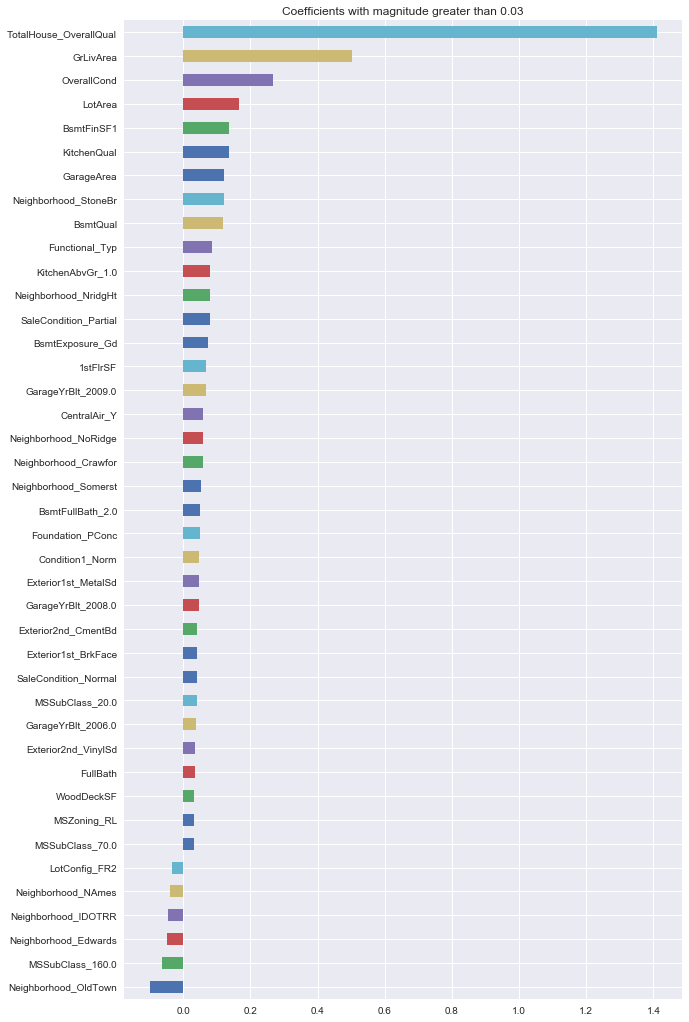

In [288]:
lasso = searchCV.best_estimator_
coefs = pd.Series(lasso.coef_,index=X.columns)

plt.figure(figsize=(10,18))
coefs[coefs.abs()>0.03].sort_values().plot.barh()
plt.title('Coefficients with magnitude greater than 0.03')

In [ ]:
#model = ElasticNet()
model = linear_model.Lasso(alpha = 0.1)
X,Y = df_train[corr_sale.index], df_train['SalePrice']

In [ ]:
model.fit(X, Y)

In [ ]:
df_test = pd.read_csv('./data/test.csv')
print(df_test.columns)

In [ ]:
for i in corr_sale.index:
    if i in X_test.columns and (X_test[i].isnull()).sum() != 0:
        print(i)
        replace = np.median(X_train[i])
        print(replace)
        X_test[i] = X_test[i].fillna(replace)

In [ ]:
#preprocessing
for i in log:
    df_test[i] = np.log(df_test[i])

In [ ]:
df_test['HasBsmt'] = pd.Series(len(df_test['TotalBsmtSF']), index=df_train.index)
df_test['HasBsmt'] = 0 
df_test.loc[df_test['TotalBsmtSF']>0,'HasBsmt'] = 1
df_test.loc[df_test['HasBsmt']==1,'TotalBsmtSF'] = np.log(df_test['TotalBsmtSF'])

In [ ]:
test_x = df_test[corr_sale.index]
print(corr_sale.index)
answer = model.predict(test_x)

In [289]:
y_test_pred = searchCV.predict(X_test)
y_test_pred = np.exp(y_test_pred)
my_submission = pd.DataFrame({'Id': X_test.index.astype(int), 'SalePrice': y_test_pred})
my_submission.to_csv('submission.csv', index=False)

![avatar](https://imgur.com/bLnQ9Yx.png)

<h3><font color="red">已暫時棄置，看起來效果沒很好</font></h3>
我們接下來要改處理negative skewness，下兩項是之前印出的結果，由他們優先處理，使用立方轉換的方法<br>
 YearBuilt
- is0: 0
- skewness: -0.613461172488183


YearRemodAdd
- is0: 0
- skewness: -0.5035620027004709

In [ ]:
i = 'YearBuilt'
print(df_train[i].skew())
sns.distplot(df_train[i], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train[i], plot=plt)

In [ ]:
i = 'YearRemodAdd'
print(df_train[i].skew())
sns.distplot(df_train[i], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train[i], plot=plt)

In [ ]:
i = 'YearRemodAdd'
for i in remaining:
    if (df_train[i]==0).sum() == 0 and df_train[i].skew()<0:
        print(i)
        df_train[i] = df_train[i]
        df_train[i] = np.power(temp[i], 3)
        #temp = temp.subtract(np.median(df_train[i]))
        #temp[i] = (temp.i - temp.i.maen())/temp[i].std(ddof=0)
        #sns.distplot(temp[i], fit=norm);
        #fig = plt.figure()
        #res = stats.probplot(temp[i], plot=plt)
        

In [ ]:
i = 'YearRemodAdd'
print(temp[i].skew())
sns.distplot(temp[i], fit=norm);
fig = plt.figure()
res = stats.probplot(temp[i], plot=plt)

In [ ]:
i = 'YearBuilt'
print(temp[i].skew())
sns.distplot(temp[i], fit=norm);
fig = plt.figure()
res = stats.probplot(temp[i], plot=plt)

雖然skewness的絕對值沒有降低多少，但至少好一些<br>
接下來換處理剩下的